In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import timedelta
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

## Setup DB

In [2]:
grople_db = create_engine("sqlite:///../db/grople.db")

## Data Analysis

In [11]:
# Load Data
data_path = Path("../csvs")
precipitation = pd.read_sql_table("precipitation", grople_db)
moisture = pd.read_sql_table("moisture", grople_db)
temperature = pd.read_sql_table("temperature", grople_db)
ndvi = pd.read_sql_table("ndvi", grople_db)
production = pd.read_sql_table("production", grople_db)
pred_production = pd.read_csv(data_path / "predicted_production_qty.csv")
data_points = pd.read_sql_table("points", grople_db)

In [12]:
print(precipitation.columns)
print(moisture.columns)
print(temperature.columns)
print(ndvi.columns)
print(production.columns)
print(data_points.columns)

Index(['region_id', 'start_date', 'end_date', 'precip'], dtype='object')
Index(['region_id', 'start_date', 'end_date', 'smos'], dtype='object')
Index(['region_id', 'start_date', 'end_date', 'temp'], dtype='object')
Index(['region_id', 'start_date', 'end_date', 'index'], dtype='object')
Index(['region_id', 'start_date', 'end_date', 'prod', 'point_id'], dtype='object')
Index(['region_id', 'date', 'point_id'], dtype='object')


In [14]:
production.dtypes

region_id              int64
start_date    datetime64[ns]
end_date      datetime64[ns]
prod                   int64
point_id               int64
dtype: object

### Date Columns Redundancy
We can see that the *start_date* and *end_date* values on many of the given datasets are identical and therefore can be combined.

In [13]:
print("Data Mismatch | Precipitation:", precipitation.loc[precipitation["start_date"] != precipitation["end_date"]])
print("Data Mismatch | Moisture:", moisture.loc[moisture["start_date"] != moisture["end_date"]])
print("Data Mismatch | Temperature:", temperature.loc[temperature["start_date"] != temperature["end_date"]])
print("Data Mismatch | ndvi:", ndvi.loc[ndvi["start_date"] != ndvi["end_date"]])
print("Data Mismatch | Production:", production.loc[production["start_date"] != production["end_date"]])

Data Mismatch | Precipitation: Empty DataFrame
Columns: [region_id, start_date, end_date, precip]
Index: []
Data Mismatch | Moisture: Empty DataFrame
Columns: [region_id, start_date, end_date, smos]
Index: []
Data Mismatch | Temperature: Empty DataFrame
Columns: [region_id, start_date, end_date, temp]
Index: []
Data Mismatch | ndvi:       region_id start_date   end_date     index
0            93 2013-12-27 2014-01-03  0.679106
1            93 2014-01-01 2014-01-08  0.701431
2            93 2014-01-09 2014-01-16  0.745149
3            93 2014-01-17 2014-01-24  0.747391
4            93 2014-01-25 2014-02-01  0.768325
...         ...        ...        ...       ...
3333        105 2022-01-09 2022-01-16  0.798257
3334        105 2022-01-17 2022-01-24  0.793242
3335        105 2022-01-25 2022-02-01  0.804884
3336        105 2022-02-18 2022-02-25  0.776287
3337        105 2022-03-06 2022-03-13  0.795875

[3338 rows x 4 columns]
Data Mismatch | Production:      region_id start_date   end_date

In [15]:
precipitation = precipitation.drop(columns="end_date")
moisture = moisture.drop(columns="end_date")
temperature = temperature.drop(columns="end_date")

## Feature Engineering
- The `end_date` column is dependent on the `start_date` column in the **`ndvi`** dataframe and therefore can be removed.

In [16]:
ndvi = ndvi.drop(columns="end_date")

- The dates in the **`production`** dataframe are dependent as well, given they represent each month of the calendar year. We can remove the end date and add a few feature representing the days in the corresponding month.

In [14]:
# Change dates type to pandas datetime
precipitation["start_date"] = pd.to_datetime(precipitation["start_date"])
moisture["start_date"] = pd.to_datetime(moisture["start_date"])
temperature["start_date"] = pd.to_datetime(temperature["start_date"])
ndvi["start_date"] = pd.to_datetime(ndvi["start_date"])
production["start_date"] = pd.to_datetime(production["start_date"])
production["end_date"] = pd.to_datetime(production["end_date"])

In [17]:
# Add new feature for number of days in month and drop end_date
production["m_days"] = (production["end_date"] - production["start_date"]).dt.days + 1
production = production.drop(columns="end_date")

### Join Dataframes
The dataframes **`precipitation`**, **`moisture`** and **`temperature`** have daily entries, all within the same date range. We can join these entries on the basis of `region_id` and `start_date`.

In [18]:
joint_df = pd.merge(precipitation, 
                    moisture, 
                    how="left", 
                    left_on=["start_date", "region_id"], 
                    right_on=["start_date", "region_id"])
joint_df = pd.merge(joint_df, 
                    temperature, 
                    how="left", 
                    left_on=["start_date", "region_id"], 
                    right_on=["start_date", "region_id"])

### Impute Missing Values
- Relatively low standard deviation in `temp`, therefore using `ffill` strategy is likely to preserve the distribution.
- There is substantial standard deviation in `smos` ($\mu=0.26, \sigma=0.09$) and the feature seems to follow a highly variant cyclic distribution as shown below. Given the significant variance, it's best to discard the rows with missing `smos` values.

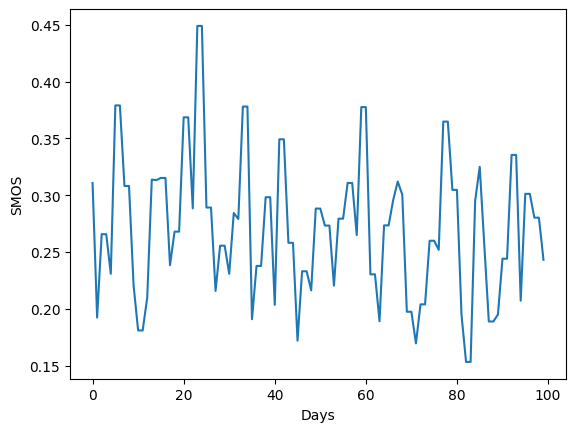

In [19]:
d = joint_df.loc[joint_df["smos"].isna() == False, :].iloc[:100]
x = pd.to_datetime(d["start_date"]).values
x = x - x[0]
x = x.astype("timedelta64[D]")
x = x / np.timedelta64(1, "D")
x

y = d["smos"].values
y

plt.plot(x, y)
plt.xlabel("Days")
plt.ylabel("SMOS")
plt.show()

In [20]:
joint_df = joint_df.sort_values(["region_id", "start_date"])
joint_df = joint_df[joint_df["smos"].notna()]
joint_df.fillna(method="ffill", inplace=True)
joint_df.isna().sum()

region_id     0
start_date    0
precip        0
smos          0
temp          1
dtype: int64

In [21]:
joint_df.fillna(method="bfill", inplace=True)
joint_df.isna().sum()

region_id     0
start_date    0
precip        0
smos          0
temp          0
dtype: int64

### Handle Date Ranges and Join
- Create 8 entries for every 8 day range in **`ndvi`** dataframe.
- The first entry in **`ndvi`** is irrelevant as it doesn't correspond to any date in other dataframes.
- Create an entry for each day in the month corresponding to `start_date` in **`production`** dataframe.

In [22]:
ndvi = ndvi.iloc[1:, :]
ndvi = ndvi.sort_values(["region_id", "start_date"])
ndvi

,region_id,start_date,index
1,93,2014-01-01,0.701431
2,93,2014-01-09,0.745149
3,93,2014-01-17,0.747391
4,93,2014-01-25,0.768325
5,93,2014-02-02,0.757172
...,...,...,...
3333,105,2022-01-09,0.798257
3334,105,2022-01-17,0.793242
3335,105,2022-01-25,0.804884
3336,105,2022-02-18,0.776287


In [23]:
cols = list(ndvi.columns) + ["curr_date"]
merge_ndvi = pd.DataFrame(columns=cols)
for _, row in ndvi.iterrows():
    new_row = {k: [row[k] for _ in range(8)] for k in row.index}
    for i in range(8):
        curr_dates = new_row.get("curr_date", [])
        curr_dates.append(new_row["start_date"][0] + timedelta(days=i))
        new_row["curr_date"] = curr_dates
    new_row = pd.DataFrame(new_row)
    merge_ndvi = pd.concat([merge_ndvi, new_row], ignore_index=True)

merge_ndvi.iloc[:20, :]

,region_id,start_date,index,curr_date
0,93,2014-01-01 00:00:00,0.701431,2014-01-01 00:00:00
1,93,2014-01-01 00:00:00,0.701431,2014-01-02 00:00:00
2,93,2014-01-01 00:00:00,0.701431,2014-01-03 00:00:00
3,93,2014-01-01 00:00:00,0.701431,2014-01-04 00:00:00
4,93,2014-01-01 00:00:00,0.701431,2014-01-05 00:00:00
5,93,2014-01-01 00:00:00,0.701431,2014-01-06 00:00:00
6,93,2014-01-01 00:00:00,0.701431,2014-01-07 00:00:00
7,93,2014-01-01 00:00:00,0.701431,2014-01-08 00:00:00
8,93,2014-01-09 00:00:00,0.745149,2014-01-09 00:00:00
9,93,2014-01-09 00:00:00,0.745149,2014-01-10 00:00:00


In [24]:
merge_ndvi["curr_date"] = pd.to_datetime(merge_ndvi["curr_date"])
merge_ndvi = merge_ndvi.drop(columns="start_date")

In [25]:
## Join NDVI to others
joint_ndvi_df = pd.merge(joint_df, 
                    merge_ndvi, 
                    how="left", 
                    left_on=["start_date", "region_id"], 
                    right_on=["curr_date", "region_id"])
joint_ndvi_df = joint_ndvi_df.drop(columns="curr_date")
joint_ndvi_df

,region_id,start_date,precip,smos,temp,index
0,93,2014-01-01,1.392393,0.310787,24.707605,0.701431
1,93,2014-01-02,0.315380,0.192271,24.707605,0.701431
2,93,2014-01-03,2.347846,0.265683,24.707605,0.701431
3,93,2014-01-04,21.466357,0.265683,24.707605,0.701431
4,93,2014-01-05,32.823651,0.230782,24.707605,0.701431
...,...,...,...,...,...,...
29778,105,2022-03-02,0.357805,0.410838,24.402574,NaN
29779,105,2022-03-03,6.955441,0.410838,24.402574,NaN
29780,105,2022-03-04,26.006624,0.442624,24.402574,NaN
29781,105,2022-03-05,16.416550,0.442624,24.402574,NaN


- Sort production by `start_date` and `region`.
- Split each monthly entry to multiple entries, one for each day of the month.
- Since production values are cumulative over a month, we evenly split them across every new entry added for each day of the month.

In [26]:
production = production.sort_values(["region_id", "start_date"])

In [27]:
cols = list(production.columns) + ["curr_date"]
merge_prod = pd.DataFrame(columns=cols)
for _, row in production.iterrows():
    m_days = row["m_days"]
    new_row = {k: [row[k] for _ in range(m_days)] for k in row.index}
    new_row["prod"] = [float(v) / m_days for v in new_row["prod"]]
    for i in range(m_days):
        curr_dates = new_row.get("curr_date", [])
        curr_dates.append(new_row["start_date"][0] + timedelta(days=i))
        new_row["curr_date"] = curr_dates
        
    new_row = pd.DataFrame(new_row)
    merge_prod = pd.concat([merge_prod, new_row], ignore_index=True)

merge_prod.iloc[:32, :]

,region_id,start_date,prod,point_id,m_days,curr_date
0,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-01 00:00:00
1,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-02 00:00:00
2,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-03 00:00:00
3,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-04 00:00:00
4,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-05 00:00:00
5,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-06 00:00:00
6,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-07 00:00:00
7,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-08 00:00:00
8,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-09 00:00:00
9,93,2015-01-01 00:00:00,5539.516129,0,31,2015-01-10 00:00:00


In [28]:
merge_prod = merge_prod.drop(columns=["start_date", "m_days"])
merge_prod["curr_date"] = pd.to_datetime(merge_prod["curr_date"])

In [29]:
## Join Production to others
joint_final = pd.merge(joint_ndvi_df, 
                    merge_prod, 
                    how="left", 
                    left_on=["start_date", "region_id"], 
                    right_on=["curr_date", "region_id"])
joint_final = joint_final.drop(columns="curr_date")
joint_final.isna().sum()

region_id        0
start_date       0
precip           0
smos             0
temp             0
index         3415
prod          7915
point_id      7915
dtype: int64

In [31]:
pd.to_numeric(joint_final["index"]).describe()

count    26368.000000
mean         0.798492
std          0.033093
min          0.573141
25%          0.784236
50%          0.805948
75%          0.821206
max          0.862471
Name: index, dtype: float64

### Handle Missing Values
- Relatively low standard deviation in `ndvi`, therefore using `ffill` strategy is likely to preserve the distribution.
- Since we're predicting **production**, we need to discard rows with missing `prod` values.

In [32]:
joint_final = joint_final[joint_final["prod"].notna()]
joint_final["index"] = pd.to_numeric(joint_final["index"])
joint_final.fillna(method="ffill", inplace=True)
joint_final["prod"] = pd.to_numeric(joint_final["prod"])

C:\Users\perfe\AppData\Local\Temp\ipykernel_860\3067113199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_final["index"] = pd.to_numeric(joint_final["index"])
C:\Users\perfe\AppData\Local\Temp\ipykernel_860\3067113199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_final.fillna(method="ffill", inplace=True)
C:\Users\perfe\AppData\Local\Temp\ipykernel_860\3067113199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [33]:
joint_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21868 entries, 363 to 29362
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   region_id   21868 non-null  int64         
 1   start_date  21868 non-null  datetime64[ns]
 2   precip      21868 non-null  float64       
 3   smos        21868 non-null  float64       
 4   temp        21868 non-null  float64       
 5   index       21868 non-null  float64       
 6   prod        21868 non-null  float64       
 7   point_id    21868 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 1.5 MB


### Handle Categorical Data
- `region_id` is categorical and therefore needs to be one-hot-encoded.

In [34]:
encoded_df = pd.merge(joint_final, 
         pd.get_dummies(joint_final["region_id"], prefix="region_id_"),
        left_index=True, 
        right_index=True)
encoded_df = encoded_df.drop(columns="region_id")
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21868 entries, 363 to 29362
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_date      21868 non-null  datetime64[ns]
 1   precip          21868 non-null  float64       
 2   smos            21868 non-null  float64       
 3   temp            21868 non-null  float64       
 4   index           21868 non-null  float64       
 5   prod            21868 non-null  float64       
 6   point_id        21868 non-null  int64         
 7   region_id__93   21868 non-null  uint8         
 8   region_id__94   21868 non-null  uint8         
 9   region_id__95   21868 non-null  uint8         
 10  region_id__97   21868 non-null  uint8         
 11  region_id__98   21868 non-null  uint8         
 12  region_id__99   21868 non-null  uint8         
 13  region_id__102  21868 non-null  uint8         
 14  region_id__103  21868 non-null  uint8         
 15  

### Handle Dates

In [35]:
final_df = encoded_df
final_df["year"] = encoded_df["start_date"].dt.year
final_df["month"] = encoded_df["start_date"].dt.month
final_df["day"] = encoded_df["start_date"].dt.day
final_df = final_df.drop(columns="start_date")

In [36]:
final_df

,precip,smos,temp,index,prod,point_id,region_id__93,region_id__94,region_id__95,region_id__97,region_id__98,region_id__99,region_id__102,region_id__103,region_id__104,region_id__105,year,month,day
363,2.278169,0.397555,23.259227,0.734261,5539.516129,0,1,0,0,0,0,0,0,0,0,0,2015,1,1
364,0.863206,0.328829,22.460309,0.734261,5539.516129,0,1,0,0,0,0,0,0,0,0,0,2015,1,2
365,0.312079,0.258153,22.460309,0.734261,5539.516129,0,1,0,0,0,0,0,0,0,0,0,2015,1,3
366,0.411836,0.258153,22.460309,0.734261,5539.516129,0,1,0,0,0,0,0,0,0,0,0,2015,1,4
367,2.275593,0.200344,22.460309,0.734261,5539.516129,0,1,0,0,0,0,0,0,0,0,0,2015,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29358,1.398462,0.403435,23.124295,0.803472,1152.516129,719,0,0,0,0,0,0,0,0,0,1,2020,12,27
29359,0.071616,0.323452,21.521947,0.803472,1152.516129,719,0,0,0,0,0,0,0,0,0,1,2020,12,28
29360,0.015141,0.323452,26.897307,0.803472,1152.516129,719,0,0,0,0,0,0,0,0,0,1,2020,12,29
29361,0.110184,0.200562,26.897307,0.803472,1152.516129,719,0,0,0,0,0,0,0,0,0,1,2020,12,30


## Preprocessing

In [37]:
inputs_df, target_df = final_df.loc[:, final_df.columns!="prod"], final_df["prod"]
inputs_df

,precip,smos,temp,index,point_id,region_id__93,region_id__94,region_id__95,region_id__97,region_id__98,region_id__99,region_id__102,region_id__103,region_id__104,region_id__105,year,month,day
363,2.278169,0.397555,23.259227,0.734261,0,1,0,0,0,0,0,0,0,0,0,2015,1,1
364,0.863206,0.328829,22.460309,0.734261,0,1,0,0,0,0,0,0,0,0,0,2015,1,2
365,0.312079,0.258153,22.460309,0.734261,0,1,0,0,0,0,0,0,0,0,0,2015,1,3
366,0.411836,0.258153,22.460309,0.734261,0,1,0,0,0,0,0,0,0,0,0,2015,1,4
367,2.275593,0.200344,22.460309,0.734261,0,1,0,0,0,0,0,0,0,0,0,2015,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29358,1.398462,0.403435,23.124295,0.803472,719,0,0,0,0,0,0,0,0,0,1,2020,12,27
29359,0.071616,0.323452,21.521947,0.803472,719,0,0,0,0,0,0,0,0,0,1,2020,12,28
29360,0.015141,0.323452,26.897307,0.803472,719,0,0,0,0,0,0,0,0,0,1,2020,12,29
29361,0.110184,0.200562,26.897307,0.803472,719,0,0,0,0,0,0,0,0,0,1,2020,12,30


Normalize only columns corresponding to `precip`, `smos`, `temp` and `ndvi`.

In [39]:
# Normalize
def normalize_grople_inp(inp_df: pd.DataFrame) -> np.ndarray:
    """
    Expects input dataframe for grople syrup training.
    """
    feature_order = ['precip', 'smos', 'temp', 
                 'index', 'region_id__93', 
                 'region_id__94', 'region_id__95', 
                 'region_id__97', 'region_id__98', 
                 'region_id__99', 'region_id__102', 
                 'region_id__103', 'region_id__104', 
                 'region_id__105', 'year', 'month', 'day']
    inp = inp_df.loc[:, feature_order].values
    target = inp[:, :4]
    mean, std = target.mean(axis=0), target.std(axis=0)
    inp[:, :4] = (inp[:, :4] - mean) / std
    
    return inp

inputs = normalize_grople_inp(inputs_df)

## Modeling and Hyperparameter Tuning

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [41]:
X, y = inputs, target_df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Exploring Various Regression Models' Cross-Validation Performance

In [ ]:
models = [LinearRegression(), Ridge(alpha=1), Ridge(alpha=0.001), SVR(C=1), SVR(kernel="poly", degree=5, C=1), SVR(kernel="poly", degree=10, C=1)]
mean_mape = []

for model in models:
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
    scores = abs(scores)
    mean_mape.append(scores)
    
for i, scores in enumerate(mean_mape):    
    print(f'{models[i]} | Mean MAPE: {np.mean(scores):.3f}, std: {np.std(scores):.3f}')

### Tree Models

In [ ]:
models = [DecisionTreeRegressor(), ExtraTreeRegressor(), RandomForestRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(n_estimators=100)]
mean_mape = []

for model in models:
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
    scores = abs(scores)
    mean_mape.append(scores)
    
for i, scores in enumerate(mean_mape):    
    print(f'{models[i]} | Mean MAPE: {np.mean(scores):.3f}, std: {np.std(scores):.3f}')

### Polynomial Features
- Nominal improvement observed for `Ridge` model.

In [ ]:
X_poly = PolynomialFeatures(degree=3).fit_transform(X)
models = [Ridge(alpha=0.00001), DecisionTreeRegressor()]
for model in models:
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
    scores = abs(scores)
    print('Mean MAPE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

### Accuracy Scores and MSE

In [ ]:
dec_tree_model = DecisionTreeRegressor(criterion="absolute_error")
dec_tree_model.fit(X_train, y_train)
dec_tree_model.score(X_test, y_test)

In [ ]:
rand_forest = RandomForestRegressor(criterion="absolute_error")
rand_forest.fit(X_train, y_train)
print(f"Score: {rand_forest.score(X_test, y_test)}")
y_pred = final_model.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

In [ ]:
ex_tree = ExtraTreesRegressor(criterion="absolute_error")
ex_tree.fit(X_train, y_train)
print(f"Score: {ex_tree.score(X_test, y_test)}")
y_pred = ex_tree.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

In [ ]:
X_train_poly = PolynomialFeatures(degree=3).fit_transform(X_train)
dec_tree_model_poly = DecisionTreeRegressor(criterion="absolute_error")
dec_tree_model_poly.fit(X_train, y_train)
y_pred = dec_tree_model_poly.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

In [ ]:
ridge = Ridge(alpha=0.000001)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

### Conclusion
Based on the experiments above, it seems that `ExtraTreesRegressor` seems to be the best model given it's extremely low **MSE** and equivalently, high **accuracy**.

## Machine Learning
### Preprocessing
#### Handle Dates

In [44]:
prediction_inp = pred_production.copy(deep=True)
prediction_inp["start_date"] = pd.to_datetime(prediction_inp["start_date"])
prediction_inp["end_date"] = pd.to_datetime(prediction_inp["end_date"])
prediction_inp["m_days"] = (prediction_inp["end_date"] - prediction_inp["start_date"]).dt.days + 1
prediction_inp = prediction_inp.drop(columns="end_date")
prediction_inp

,start_date,prod,region_id,m_days
0,2021-01-01 00:00:00+00:00,184890.000000,93,31
1,2021-02-01 00:00:00+00:00,219635.822625,93,28
2,2021-03-01 00:00:00+00:00,241874.530000,93,31
3,2021-04-01 00:00:00+00:00,274088.812258,93,30
4,2021-05-01 00:00:00+00:00,261296.033000,93,31
...,...,...,...,...
115,2021-08-01 00:00:00+00:00,35289.530000,105,31
116,2021-09-01 00:00:00+00:00,45094.224516,105,30
117,2021-10-01 00:00:00+00:00,43075.829333,105,31
118,2021-11-01 00:00:00+00:00,54395.003548,105,30


#### Join other features

In [45]:
# Join Production to others
joint_pred = pd.merge(prediction_inp,
                    joint_ndvi_df, 
                    how="left", 
                    left_on=["start_date", "region_id"], 
                    right_on=["start_date", "region_id"])
joint_pred["ndvi"] = pd.to_numeric(joint_pred["ndvi"])
joint_pred

,start_date,prod,region_id,m_days,precip,smos,temp,ndvi
0,2021-01-01 00:00:00+00:00,184890.000000,93,31,72.080973,0.440242,26.732938,0.812302
1,2021-02-01 00:00:00+00:00,219635.822625,93,28,0.818350,0.342650,24.764539,0.792559
2,2021-03-01 00:00:00+00:00,241874.530000,93,31,1.716950,0.279426,31.882281,0.760901
3,2021-04-01 00:00:00+00:00,274088.812258,93,30,1.141970,0.290524,29.001614,0.794951
4,2021-05-01 00:00:00+00:00,261296.033000,93,31,8.447337,0.329901,27.375288,0.812450
...,...,...,...,...,...,...,...,...
120,2021-08-01 00:00:00+00:00,35289.530000,105,31,4.091963,0.310629,25.023290,0.812074
121,2021-09-01 00:00:00+00:00,45094.224516,105,30,15.836336,0.215496,24.362179,0.832753
122,2021-10-01 00:00:00+00:00,43075.829333,105,31,14.073140,0.245065,25.729792,0.806624
123,2021-11-01 00:00:00+00:00,54395.003548,105,30,7.814641,0.395637,26.076902,0.792906


#### Handle Categorical Data, Explode Date into Features, Impute Missing Values
- Since each row represents a month, imputing `ndvi` with `ffill` (or `bfill`) will likely skew the distribution towards the next available row. Better to use mean value.

In [49]:
# One-hot Encoding
encoded_pred = pd.merge(joint_pred, 
         pd.get_dummies(joint_pred["region_id"], prefix="region_id_"),
        left_index=True, 
        right_index=True)
encoded_pred = encoded_pred.drop(columns="region_id")

# Date to features
final_pred = encoded_pred
final_pred["year"] = encoded_pred["start_date"].dt.year
final_pred["month"] = encoded_pred["start_date"].dt.month
final_pred["day"] = encoded_pred["start_date"].dt.day
final_pred = final_pred.drop(columns="start_date")
print(final_pred.isna().sum())

# Impute values
final_pred["ndvi"] = final_pred["ndvi"].fillna(final_pred["ndvi"].mean())
final_pred.isna().sum()

prod              0
m_days            0
precip            0
smos              0
temp              0
ndvi              9
region_id__93     0
region_id__94     0
region_id__95     0
region_id__97     0
region_id__98     0
region_id__99     0
region_id__102    0
region_id__103    0
region_id__104    0
region_id__105    0
year              0
month             0
day               0
dtype: int64


/Users/sarthak/Repos/Gro Assessment/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,prod,m_days,precip,smos,temp,ndvi,region_id__93,region_id__94,region_id__95,region_id__97,region_id__98,region_id__99,region_id__102,region_id__103,region_id__104,region_id__105,year,month,day
0,184890.000000,31,72.080973,0.440242,26.732938,0.812302,1,0,0,0,0,0,0,0,0,0,2021,1,1
1,219635.822625,28,0.818350,0.342650,24.764539,0.792559,1,0,0,0,0,0,0,0,0,0,2021,2,1
2,241874.530000,31,1.716950,0.279426,31.882281,0.760901,1,0,0,0,0,0,0,0,0,0,2021,3,1
3,274088.812258,30,1.141970,0.290524,29.001614,0.794951,1,0,0,0,0,0,0,0,0,0,2021,4,1
4,261296.033000,31,8.447337,0.329901,27.375288,0.812450,1,0,0,0,0,0,0,0,0,0,2021,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,35289.530000,31,4.091963,0.310629,25.023290,0.812074,0,0,0,0,0,0,0,0,0,1,2021,8,1
121,45094.224516,30,15.836336,0.215496,24.362179,0.832753,0,0,0,0,0,0,0,0,0,1,2021,9,1
122,43075.829333,31,14.073140,0.245065,25.729792,0.806624,0,0,0,0,0,0,0,0,0,1,2021,10,1
123,54395.003548,30,7.814641,0.395637,26.076902,0.792906,0,0,0,0,0,0,0,0,0,1,2021,11,1


### Inference
- Since our model is trained to predict production values for any given day of a month on average, we can get monthly production estimates by simply multiplying the output with corresponding number of days in the month.

In [51]:
X_pred = normalize_grople_inp(final_pred)
y_pred = ex_tree.predict(X_pred)
pred_production.loc[:, "prod"] = y_pred * final_pred["m_days"]
pred_production

,start_date,end_date,prod,region_id
0,2021-01-01T00:00:00.000Z,2021-01-31T00:00:00.000Z,184890.000000,93
1,2021-02-01T00:00:00.000Z,2021-02-28T00:00:00.000Z,219635.822625,93
2,2021-03-01T00:00:00.000Z,2021-03-31T00:00:00.000Z,241874.530000,93
3,2021-04-01T00:00:00.000Z,2021-04-30T00:00:00.000Z,274088.812258,93
4,2021-05-01T00:00:00.000Z,2021-05-31T00:00:00.000Z,261296.033000,93
...,...,...,...,...
115,2021-08-01T00:00:00.000Z,2021-08-31T00:00:00.000Z,35289.530000,105
116,2021-09-01T00:00:00.000Z,2021-09-30T00:00:00.000Z,45094.224516,105
117,2021-10-01T00:00:00.000Z,2021-10-31T00:00:00.000Z,42830.558000,105
118,2021-11-01T00:00:00.000Z,2021-11-30T00:00:00.000Z,54389.933548,105


In [52]:
pred_production.to_csv("output/sj2810@nyu.edu.csv", index=False)